In [41]:
from src.libs.lib import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


df_todos_retroativos = pd.read_csv("src/data/df_todos_retroativos.csv")
df_todos_retroativos = df_todos_retroativos.loc[:, ~df_todos_retroativos.columns.str.contains('^Unnamed')] 
df_todos_retroativos['periodo'] = pd.to_datetime(df_todos_retroativos['periodo'])

df_original = pd.read_csv("src/data/df_original.csv")
df_original = df_original.loc[:, ~df_original.columns.str.contains('^Unnamed')] 
df_original['periodo'] = pd.to_datetime(df_original['periodo'])

df_comparativo = pd.read_csv("src/data/df_comparativo.csv")
df_comparativo = df_comparativo.loc[:, ~df_comparativo.columns.str.contains('^Unnamed')] 
df_comparativo['ano_mes'] = pd.to_datetime(df_comparativo['ano_mes'])

df_transportadoras = pd.read_csv("src/data/df_transportadoras.csv")
df_transportadoras = df_transportadoras.loc[:, ~df_transportadoras.columns.str.contains('^Unnamed')] 

#2.6s

# empresas com mais dias removidos

In [42]:
df_transportadoras

company_id                            company_name  freight_id  \
0            3130                   OPR Logistica Pontual      140386   
1            1022                        LOG20 - Londrina      139335   
2             215                   IC TRANSPORTES TANQUE      139401   
3            3645                       Madri Express Log      139305   
4            2432          Kona Transportes - Itapecerica      139304   
...           ...                                     ...         ...   
11717        3412                  EVM EVOLUTION MOBILITY      158756   
11718        3335                                 Fit Log      159118   
11719        1047  Casa Assistencial Maria Helena Paulina      158715   
11720         704                       ORIENTE LOGISTICA      159132   
11721         704                       ORIENTE LOGISTICA      159126   

       dias_reducao houve_reducao  
0               NaN           nao  
1               NaN           nao  
2               4.0           sim  
3               NaN           nao  
4               NaN           nao  
...             ...           ...  
11717           NaN           nao  
11718           NaN           nao  
11719           NaN           nao  
11720           NaN           nao  
11721           NaN           nao  

[11722 rows x 5 columns]

In [43]:
# Criar colunas auxiliares para contagem condicional
df_transportadoras["com_reducao"] = df_transportadoras["houve_reducao"] == "sim"
df_transportadoras["sem_reducao"] = df_transportadoras["houve_reducao"] != "sim"

# Agrupar e calcular os dados desejados
resumo_final = (
    df_transportadoras.groupby(["company_id", "company_name"])
    .agg(
        total_contratos=("freight_id", "count"),
        com_reducao=("com_reducao", "sum"),
        sem_reducao=("sem_reducao", "sum"),
        total_dias_reducao=("dias_reducao", "sum")
    )
    .reset_index()
    .sort_values("com_reducao", ascending=False)
)
resumo_final["porcentagem_reducao"] = (
    resumo_final["com_reducao"] / resumo_final["total_contratos"]
).round(3) * 100  # porcentagem com 1 casa decimal

resumo_filtrado = resumo_final[resumo_final["total_contratos"] >= 10].copy()
resumo_final.head(20)


company_id                                       company_name  \
275        2103                                      FSJ - JANAINA   
277        2124                                  FSJ - JO√ÉO VICTOR   
138         953                                        TRANSDANIEL   
136         948                   TECMAR TRANSPORTES LTDA - MATRIZ   
30          249                             TRANSPORTES TOZZO LTDA   
71          455                       TRANSRIMA TRANSPORTES EIRELI   
212        1365  STEEL LOG - COMERCIO, LOGISTICA, TRANSPORTADOR...   
386        3126                                       FSJ - CARLOS   
64          425                         TRANSPORTES FRAMENTO LTDA.   
94          598                                FSJ - MATHEUS VIVOT   
24          215                              IC TRANSPORTES TANQUE   
274        2102                                      FSJ - CLAUDIA   
27          229                          IC TRANSPORTES AIRLIQUIDE   
388        3130                              OPR Logistica Pontual   
299        2308                         CORDIOLLI TRANSPORTES LTDA   
475        3746                                      FSJ - VANESSA   
417        3344                                        Grupo Urbam   
70          446                         Transportes Ma√ßaneiro LTDA   
209        1359                   TRANZAL TRANSPORTES ZANELLA LTDA   
33          265                   TRANSPORTES CORDENONSI LTDA - SP   

     total_contratos  com_reducao  sem_reducao  total_dias_reducao  \
275              194           46          148               214.0   
277              148           30          118                58.5   
138              303           29          274               140.0   
136              130           27          103               297.5   
30               209           23          186                71.0   
71               111           23           88                61.5   
212               64           22           42               131.5   
386              177           21          156                87.5   
64               136           21          115                57.5   
94               133           21          112                50.0   
24               241           20          221                98.5   
274              149           20          129                44.0   
27               122           18          104                36.0   
388              362           17          345                41.0   
299               64           16           48                63.0   
475              164           16          148                74.0   
417               59           16           43               174.0   
70                47           14           33               235.0   
209               75           14           61                34.0   
33                81           13           68                37.5   

     porcentagem_reducao  
275                 23.7  
277                 20.3  
138                  9.6  
136                 20.8  
30                  11.0  
71                  20.7  
212                 34.4  
386                 11.9  
64                  15.4  
94                  15.8  
24                   8.3  
274                 13.4  
27                  14.8  
388                  4.7  
299                 25.0  
475                  9.8  
417                 27.1  
70                  29.8  
209                 18.7  
33                  16.0

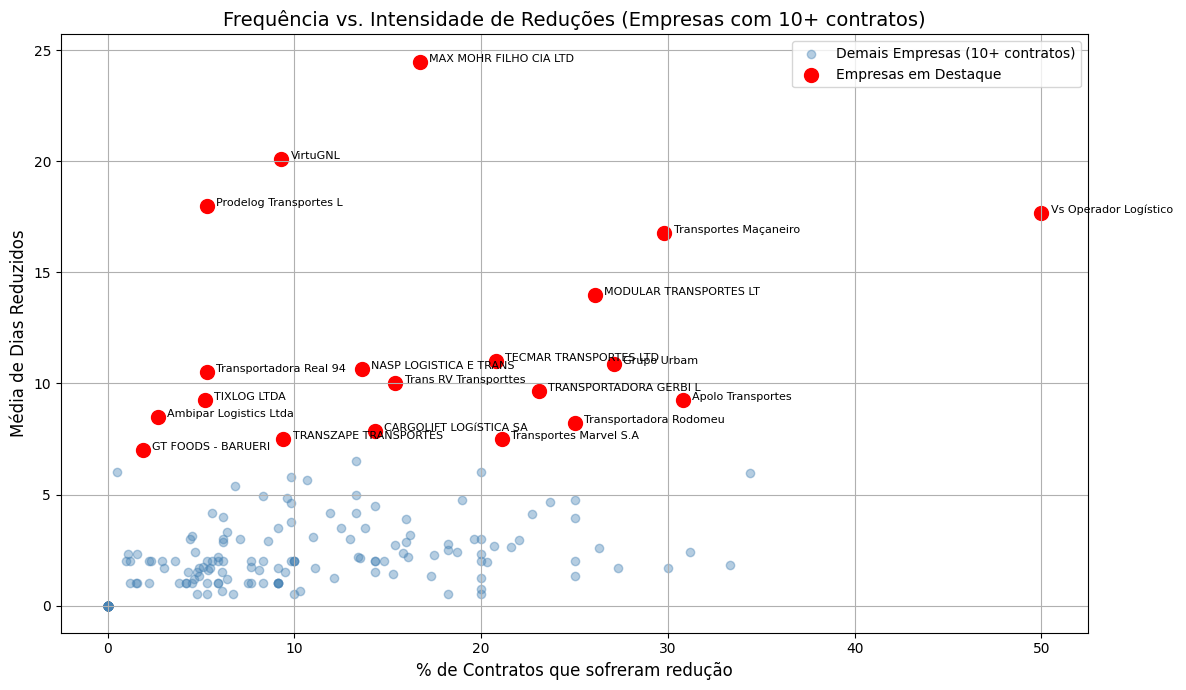

In [44]:
# 2. Calcular a m√©dia de dias reduzidos entre contratos que tiveram redu√ß√£o
resumo_filtrado["media_dias_reducao"] = (
    resumo_filtrado["total_dias_reducao"] / resumo_filtrado["com_reducao"]
).replace([float('inf'), -float('inf')], 0).fillna(0).round(2)

# 3. Selecionar os 20 destaques com maior m√©dia de dias reduzidos
destaques = resumo_filtrado.sort_values("media_dias_reducao", ascending=False).head(20)

# 4. Gerar o gr√°fico
plt.figure(figsize=(12, 7))

# Todos os pontos
plt.scatter(
    resumo_filtrado["porcentagem_reducao"],
    resumo_filtrado["media_dias_reducao"],
    color="steelblue",
    alpha=0.4,
    label="Demais Empresas (10+ contratos)"
)

# Destaques
plt.scatter(
    destaques["porcentagem_reducao"],
    destaques["media_dias_reducao"],
    color="red",
    edgecolor="red",
    s=100,
    label="Empresas em Destaque"
)

# Anotar os nomes das empresas destacadas
for _, row in destaques.iterrows():
    plt.text(
        row["porcentagem_reducao"] + 0.5,
        row["media_dias_reducao"],
        str(row["company_name"])[:22],
        fontsize=8
    )

# Est√©tica
plt.title("Frequ√™ncia vs. Intensidade de Redu√ß√µes (Empresas com 10+ contratos)", fontsize=14)
plt.xlabel("% de Contratos que sofreram redu√ß√£o", fontsize=12)
plt.ylabel("M√©dia de Dias Reduzidos", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


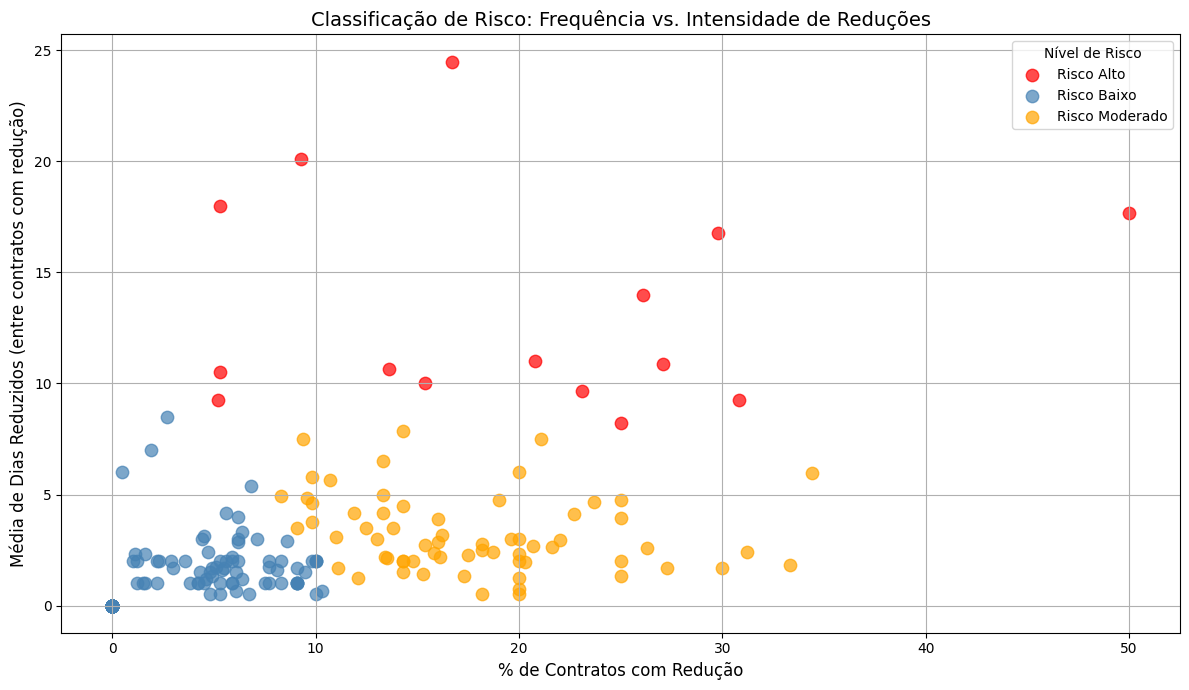

In [45]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. Calcular a m√©dia de dias reduzidos entre os contratos com redu√ß√£o
resumo_final["media_dias_reducao"] = (
    resumo_final["total_dias_reducao"] / resumo_final["com_reducao"]
).replace([float("inf"), -float("inf")], 0).fillna(0).round(2)

# 2. Filtrar empresas com pelo menos 10 contratos
resumo_filtrado = resumo_final[resumo_final["total_contratos"] >= 10].copy()

# 3. Preparar dados para clusteriza√ß√£o
X = resumo_filtrado[["porcentagem_reducao", "media_dias_reducao"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Aplicar KMeans com 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")
resumo_filtrado["grupo_risco"] = kmeans.fit_predict(X_scaled)

# 5. Nomear os clusters como Baixo, Moderado, Alto
centros = scaler.inverse_transform(kmeans.cluster_centers_)
ordem_risco = centros[:, 0] + centros[:, 1]  # soma da frequ√™ncia + intensidade
mapeamento = {i: risco for i, risco in zip(ordem_risco.argsort(), ["Baixo", "Moderado", "Alto"])}
resumo_filtrado["categoria_risco"] = resumo_filtrado["grupo_risco"].map(mapeamento)

# 6. Gerar gr√°fico com 3 cores por n√≠vel de risco
cores = {"Baixo": "steelblue", "Moderado": "orange", "Alto": "red"}

plt.figure(figsize=(12, 7))

for categoria, grupo_df in resumo_filtrado.groupby("categoria_risco"):
    plt.scatter(
        grupo_df["porcentagem_reducao"],
        grupo_df["media_dias_reducao"],
        label=f"Risco {categoria}",
        color=cores[categoria],
        edgecolor="red" if categoria == "Alto" else None,
        s=80,
        alpha=0.7
    )

plt.title("Classifica√ß√£o de Risco: Frequ√™ncia vs. Intensidade de Redu√ß√µes", fontsize=14)
plt.xlabel("% de Contratos com Redu√ß√£o", fontsize=12)
plt.ylabel("M√©dia de Dias Reduzidos (entre contratos com redu√ß√£o)", fontsize=12)
plt.grid(True)
plt.legend(title="N√≠vel de Risco")
plt.tight_layout()
plt.show()


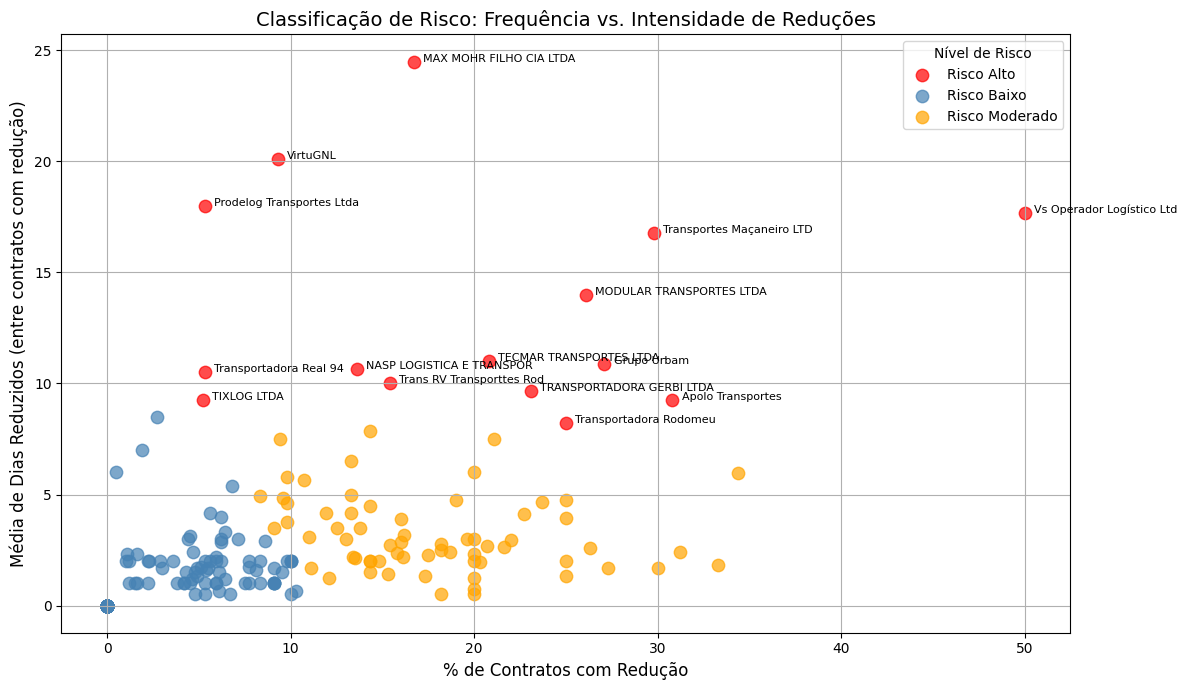

In [46]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Recalcular a m√©trica de intensidade m√©dia se necess√°rio
resumo_final["media_dias_reducao"] = (
    resumo_final["total_dias_reducao"] / resumo_final["com_reducao"]
).replace([float("inf"), -float("inf")], 0).fillna(0).round(2)

# Filtrar empresas com pelo menos 10 contratos
resumo_filtrado = resumo_final[resumo_final["total_contratos"] >= 10].copy()

# Clusteriza√ß√£o
X = resumo_filtrado[["porcentagem_reducao", "media_dias_reducao"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
resumo_filtrado["grupo_risco"] = kmeans.fit_predict(X_scaled)

# Nomear os grupos
centros = scaler.inverse_transform(kmeans.cluster_centers_)
ordem_risco = centros[:, 0] + centros[:, 1]
mapeamento = {i: risco for i, risco in zip(ordem_risco.argsort(), ["Baixo", "Moderado", "Alto"])}
resumo_filtrado["categoria_risco"] = resumo_filtrado["grupo_risco"].map(mapeamento)

# üî¥ Gerar o gr√°fico com nomes apenas para empresas de risco alto
cores = {"Baixo": "steelblue", "Moderado": "orange", "Alto": "red"}

plt.figure(figsize=(12, 7))

# Plotar todos os grupos com cores
for categoria, grupo_df in resumo_filtrado.groupby("categoria_risco"):
    plt.scatter(
        grupo_df["porcentagem_reducao"],
        grupo_df["media_dias_reducao"],
        color=cores[categoria],
        edgecolor="red" if categoria == "Alto" else None,
        s=80,
        alpha=0.7,
        label=f"Risco {categoria}"
    )

# Nomear apenas os pontos do grupo de risco alto
grupo_alto = resumo_filtrado[resumo_filtrado["categoria_risco"] == "Alto"]
for _, row in grupo_alto.iterrows():
    plt.text(
        row["porcentagem_reducao"] + 0.5,
        row["media_dias_reducao"],
        str(row["company_name"])[:25],
        fontsize=8
    )

plt.title("Classifica√ß√£o de Risco: Frequ√™ncia vs. Intensidade de Redu√ß√µes", fontsize=14)
plt.xlabel("% de Contratos com Redu√ß√£o", fontsize=12)
plt.ylabel("M√©dia de Dias Reduzidos (entre contratos com redu√ß√£o)", fontsize=12)
plt.grid(True)
plt.legend(title="N√≠vel de Risco")
plt.tight_layout()
plt.show()


In [47]:
resumo_filtrado

company_id                      company_name  total_contratos  \
275        2103                     FSJ - JANAINA              194   
277        2124                 FSJ - JO√ÉO VICTOR              148   
138         953                       TRANSDANIEL              303   
136         948  TECMAR TRANSPORTES LTDA - MATRIZ              130   
30          249            TRANSPORTES TOZZO LTDA              209   
..          ...                               ...              ...   
479        3783  Univale Distribuidora de Bebidas               10   
481        3822           IMPERIO BEBIDAS - Serra               41   
532        4150      DISTRIBUIDORA MENEGAZZO LTDA               11   
0             6         ACEVILLE TRANSPORTES LTDA               23   
543        4322             IMPACTO DISTRIBUIDORA               10   

     com_reducao  sem_reducao  total_dias_reducao  porcentagem_reducao  \
275           46          148               214.0                 23.7   
277           30          118                58.5                 20.3   
138           29          274               140.0                  9.6   
136           27          103               297.5                 20.8   
30            23          186                71.0                 11.0   
..           ...          ...                 ...                  ...   
479            0           10                 0.0                  0.0   
481            0           41                 0.0                  0.0   
532            0           11                 0.0                  0.0   
0              0           23                 0.0                  0.0   
543            0           10                 0.0                  0.0   

     media_dias_reducao  grupo_risco categoria_risco  
275                4.65            2        Moderado  
277                1.95            2        Moderado  
138                4.83            2        Moderado  
136               11.02            1            Alto  
30                 3.09            2        Moderado  
..                  ...          ...             ...  
479                0.00            0           Baixo  
481                0.00            0           Baixo  
532                0.00            0           Baixo  
0                  0.00            0           Baixo  
543                0.00            0           Baixo  

[219 rows x 10 columns]

In [48]:
# Agora calcular as caracter√≠sticas m√©dias por grupo de risco
caracteristicas_risco = (
    resumo_filtrado.groupby("categoria_risco")
    .agg(
        media_total_contratos=("total_contratos", "mean"),
        media_contratos_com_reducao=("com_reducao", "mean"),
        media_porcentagem_reducao=("porcentagem_reducao", "mean"),
        media_dias_reducao=("media_dias_reducao", "mean"),
        empresas_no_grupo=("company_id", "count")
    )
    .round(1)
    .reset_index()
)

caracteristicas_risco.sort_values("categoria_risco", ascending=False)

categoria_risco  media_total_contratos  media_contratos_com_reducao  \
2        Moderado                   59.1                          9.1   
1           Baixo                   44.5                          1.4   
0            Alto                   34.7                          6.5   

   media_porcentagem_reducao  media_dias_reducao  empresas_no_grupo  
2                       17.6                 3.2                 65  
1                        2.9                 1.0                139  
0                       20.2                13.4                 15

# AN√ÅLISE DO PER√çODO AVALIADO

In [49]:
import pandas as pd

# Contagem de contratos com redu√ß√£o (df_original)
contagem_original = (
    df_original
    .groupby(['periodo', 'tipo', 'nivel_px'])
    .agg(qt_freights_original=('freight_id', 'nunique'))
    .reset_index()
)

# Contagem de todos os contratos analisados (df_todos_retroativos)
contagem_retroativos = (
    df_todos_retroativos
    .groupby(['periodo', 'tipo', 'nivel_px'])
    .agg(qt_freights_retroativos=('freight_id', 'nunique'))
    .reset_index()
)

# Juntar as duas contagens por periodo, tipo e nivel_px
contagem_combinada = pd.merge(
    contagem_original,
    contagem_retroativos,
    on=['periodo', 'tipo', 'nivel_px'],
    how='outer'
)

# Preencher valores nulos com zero e garantir que s√£o inteiros
contagem_combinada.fillna(0, inplace=True)
contagem_combinada[['qt_freights_original', 'qt_freights_retroativos']] = contagem_combinada[
    ['qt_freights_original', 'qt_freights_retroativos']
].astype(int)

# Calcular propor√ß√£o de contratos com redu√ß√£o
contagem_combinada['proporcao_contratos_com_retroativos'] = (
    contagem_combinada['qt_freights_original'] / contagem_combinada['qt_freights_retroativos']
).round(4)

# Resultado final com as colunas relevantes
tabela_final = contagem_combinada[
    ['periodo', 'tipo', 'nivel_px', 'qt_freights_original', 'qt_freights_retroativos', 'proporcao_contratos_com_retroativos']
]

tabela_final


periodo            tipo  nivel_px  qt_freights_original  \
0  2025-02-01  Coleta/Entrega    Bronze                     3   
1  2025-02-01  Coleta/Entrega  Diamante                     7   
2  2025-02-01  Coleta/Entrega      Ouro                    15   
3  2025-02-01  Coleta/Entrega     Prata                     6   
4  2025-02-01          Di√°ria    Bronze                     4   
..        ...             ...       ...                   ...   
59 2025-04-11  Coleta/Entrega     Prata                     4   
60 2025-04-11          Di√°ria    Bronze                     0   
61 2025-04-11          Di√°ria  Diamante                     7   
62 2025-04-11          Di√°ria      Ouro                    11   
63 2025-04-11          Di√°ria     Prata                     3   

    qt_freights_retroativos  proporcao_contratos_com_retroativos  
0                        42                               0.0714  
1                       185                               0.0378  
2                       260                               0.0577  
3                        83                               0.0723  
4                        26                               0.1538  
..                      ...                                  ...  
59                       68                               0.0588  
60                        5                               0.0000  
61                       92                               0.0761  
62                      143                               0.0769  
63                       44                               0.0682  

[64 rows x 6 columns]

In [ ]:
tabela_final.

In [50]:
print(contagem_combinada.periodo.min())
print(contagem_combinada.periodo.max())

2025-02-01 00:00:00
2025-04-11 00:00:00


Foi avaliado o per√≠odo 01/02/2025 a 21/04/25.

Nesse intervalo, foram considerados intervalos de 10 dias para identifica√ß√£o de padr√µes de comportamento.

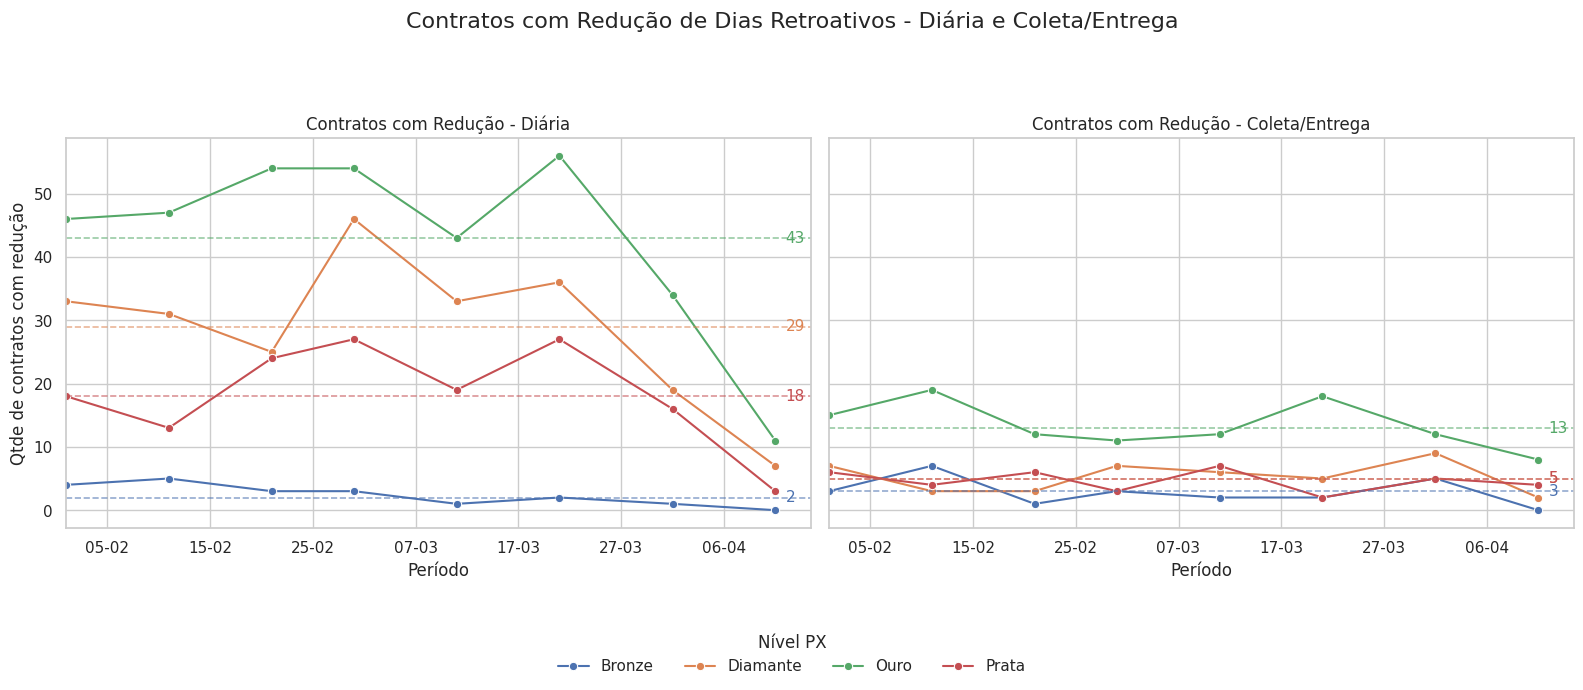

In [51]:
# Recriar gr√°fico com legenda correta no topo ‚Äî removendo as internas e mantendo a global

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Estilo e figura
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

tipos_desejados = ['Di√°ria', 'Coleta/Entrega']
cores_niveis = {}
handles_legenda, labels_legenda = None, None

for ax, tipo in zip(axes, tipos_desejados):
    dados_tipo = tabela_final[tabela_final['tipo'] == tipo]

    # Plot principal (com legenda apenas no primeiro gr√°fico para capturar os handles)
    plot = sns.lineplot(
        data=dados_tipo,
        x='periodo',
        y='qt_freights_original',
        hue='nivel_px',
        marker='o',
        ax=ax
    )

    # Capturar legendas apenas uma vez
    if handles_legenda is None:
        handles_legenda, labels_legenda = plot.get_legend_handles_labels()
    ax.legend_.remove()  # Remove legenda interna do subplot

    # Captura de cores
    for line, label in zip(plot.lines, dados_tipo['nivel_px'].unique()):
        if label not in cores_niveis:
            cores_niveis[label] = line.get_color()

    # M√©dias com anota√ß√£o
    medias = (
        dados_tipo.groupby('nivel_px')['qt_freights_original']
        .mean()
        .round()
        .astype(int)
        .to_dict()
    )

    for nivel, media in medias.items():
        ax.axhline(
            y=media,
            linestyle='--',
            linewidth=1.2,
            color=cores_niveis[nivel],
            alpha=0.6
        )
        ax.text(
            dados_tipo['periodo'].max()+ pd.Timedelta(days=1),
            media,
            f"{media}",
            va='center',
            ha='left',
            color=cores_niveis[nivel],
            fontsize=11
        )

    # Eixo X com data formatada e intervalo correto
    ax.set_title(f'Contratos com Redu√ß√£o - {tipo}', fontsize=12)
    ax.set_xlabel("Per√≠odo")
    ax.set_ylabel("Qtde de contratos com redu√ß√£o")
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
    ax.set_xlim(left=pd.Timestamp('2025-02-01'))

# Legenda √∫nica e vis√≠vel
fig.legend(
    handles_legenda,
    labels_legenda,
    title="N√≠vel PX",
    loc='lower center',
    bbox_to_anchor=(0.5, -0.15),  # <- ajusta mais para baixo
    ncol=4,
    frameon=False
)

fig.suptitle("Contratos com Redu√ß√£o de Dias Retroativos - Di√°ria e Coleta/Entrega", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.show()


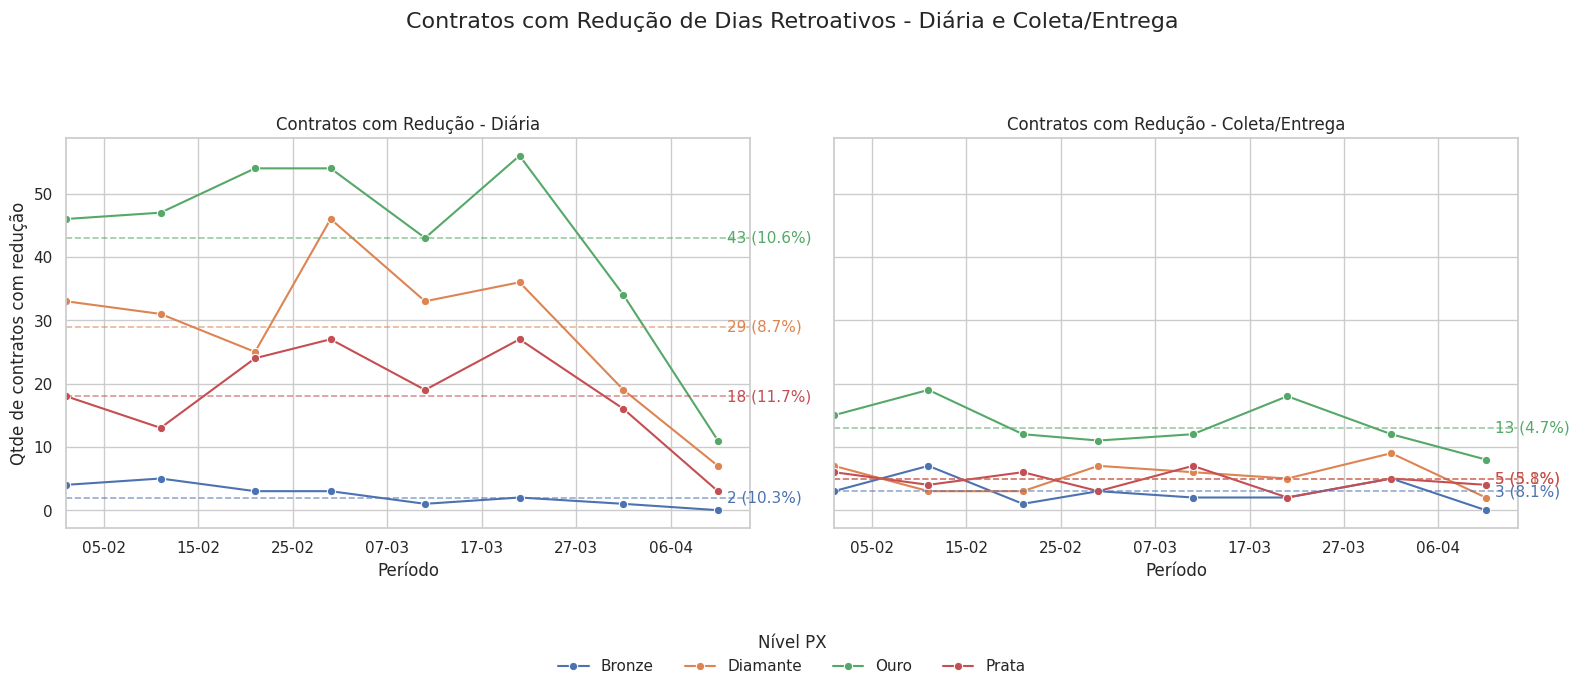

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd

# Estilo visual
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

tipos_desejados = ['Di√°ria', 'Coleta/Entrega']
cores_niveis = {}
handles_legenda, labels_legenda = None, None

for ax, tipo in zip(axes, tipos_desejados):
    dados_tipo = tabela_final[tabela_final['tipo'] == tipo]

    # Linha principal
    plot = sns.lineplot(
        data=dados_tipo,
        x='periodo',
        y='qt_freights_original',
        hue='nivel_px',
        marker='o',
        ax=ax
    )

    # Pegar legenda apenas uma vez
    if handles_legenda is None:
        handles_legenda, labels_legenda = plot.get_legend_handles_labels()
    ax.legend_.remove()

    # Mapear cores dos n√≠veis
    for line, label in zip(plot.lines, dados_tipo['nivel_px'].unique()):
        if label not in cores_niveis:
            cores_niveis[label] = line.get_color()

    # M√©dias absolutas
    medias = (
        dados_tipo.groupby('nivel_px')['qt_freights_original']
        .mean()
        .round()
        .astype(int)
        .to_dict()
    )

    # M√©dias percentuais
    medias_pct = (
        dados_tipo.groupby('nivel_px')['proporcao_contratos_com_retroativos']
        .mean()
        .mul(100)
        .round(1)
        .to_dict()
    )

    for nivel, media_abs in medias.items():
        media_pct = medias_pct.get(nivel, 0.0)
        texto = f"{media_abs} ({media_pct:.1f}%)"

        ax.axhline(
            y=media_abs,
            linestyle='--',
            linewidth=1.2,
            color=cores_niveis[nivel],
            alpha=0.6
        )
        ax.text(
            dados_tipo['periodo'].max() + pd.Timedelta(days=1),
            media_abs,
            texto,
            va='center',
            ha='left',
            color=cores_niveis[nivel],
            fontsize=11
        )

    # Configura√ß√µes do eixo
    ax.set_title(f'Contratos com Redu√ß√£o - {tipo}', fontsize=12)
    ax.set_xlabel("Per√≠odo")
    ax.set_ylabel("Qtde de contratos com redu√ß√£o")
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
    ax.set_xlim(left=pd.Timestamp('2025-02-01'))

# Legenda √∫nica
fig.legend(
    handles_legenda,
    labels_legenda,
    title="N√≠vel PX",
    loc='lower center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=4,
    frameon=False
)

fig.suptitle("Contratos com Redu√ß√£o de Dias Retroativos - Di√°ria e Coleta/Entrega", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.show()


O gr√°fico apresenta a quantidade m√©dia de contratos com redu√ß√£o de dias retroativos ao longo do tempo, separada por tipo de contrato (Di√°ria e Coleta/Entrega) e por n√≠vel PX (Bronze, Prata, Ouro, Diamante). Cada ponto representa a m√©dia registrada em um per√≠odo de 10 dias, permitindo observar varia√ß√µes e tend√™ncias por perfil de contrato. As linhas tracejadas horizontais indicam a m√©dia geral de cada n√≠vel PX durante o per√≠odo analisado, funcionando como uma refer√™ncia visual para avaliar se determinados per√≠odos ficaram acima ou abaixo do comportamento t√≠pico daquele grupo.

O comportamento dos contratos Di√°rios mostra varia√ß√µes mais expressivas, especialmente nos n√≠veis Ouro e Diamante, enquanto os contratos de Coleta/Entrega apresentaram maior estabilidade, com valores absolutos mais baixos e consist√™ncia entre os n√≠veis. Esses padr√µes ajudam a identificar os perfis mais propensos a ajustes retroativos e podem apoiar decis√µes de monitoramento mais espec√≠fico ou revis√£o de pol√≠ticas operacionais.

In [52]:
import pandas as pd

# Supondo que 'tabela_final' j√° esteja carregada e contenha:
# ['tipo', 'nivel_px', 'periodo', 'qt_freights_original', 'qt_freights_retroativos']

# Etapa 1: Agrega√ß√µes a cada 10 dias por tipo e n√≠vel
total_reduzidos_nivel = (
    tabela_final
    .groupby(['tipo', 'nivel_px', 'periodo'])['qt_freights_original']
    .sum()
    .reset_index(name='qt_contratos_com_reducao')
)

total_geral_nivel = (
    tabela_final
    .groupby(['tipo', 'nivel_px', 'periodo'])['qt_freights_retroativos']
    .sum()
    .reset_index(name='qt_contratos_total')
)

tabela_taxa_nivel = pd.merge(total_reduzidos_nivel, total_geral_nivel, on=['tipo', 'nivel_px', 'periodo'])
tabela_taxa_nivel['proporcao'] = tabela_taxa_nivel['qt_contratos_com_reducao'] / tabela_taxa_nivel['qt_contratos_total']

# Etapa 2: M√©dias e proje√ß√µes mensais
resumo_taxa_nivel = (
    tabela_taxa_nivel
    .groupby(['tipo', 'nivel_px'])
    .agg(
        media_contratos_com_reducao=('qt_contratos_com_reducao', 'mean'),
        media_contratos_total=('qt_contratos_total', 'mean'),
        media_proporcao=('proporcao', 'mean')
    )
    .reset_index()
)

resumo_taxa_nivel['estimado_mensal_reducao'] = (resumo_taxa_nivel['media_contratos_com_reducao'] * 3).round(0).astype(int)
resumo_taxa_nivel['estimado_mensal_total'] = (resumo_taxa_nivel['media_contratos_total'] * 3).round(0).astype(int)
resumo_taxa_nivel['estimado_mensal_percentual'] = (resumo_taxa_nivel['media_proporcao'] * 100).round(1)


In [54]:
resumo_taxa_nivel

tipo  nivel_px  media_contratos_com_reducao  \
0  Coleta/Entrega    Bronze                        2.875   
1  Coleta/Entrega  Diamante                        5.250   
2  Coleta/Entrega      Ouro                       13.375   
3  Coleta/Entrega     Prata                        4.625   
4          Di√°ria    Bronze                        2.375   
5          Di√°ria  Diamante                       28.750   
6          Di√°ria      Ouro                       43.125   
7          Di√°ria     Prata                       18.375   

   media_contratos_total  media_proporcao  estimado_mensal_reducao  \
0                 32.250         0.080792                        9   
1                170.000         0.030563                       16   
2                283.500         0.046782                       40   
3                 80.500         0.058001                       14   
4                 19.875         0.102940                        7   
5                325.375         0.086886                       86   
6                399.625         0.105965                      129   
7                151.625         0.117266                       55   

   estimado_mensal_total  estimado_mensal_percentual  
0                     97                         8.1  
1                    510                         3.1  
2                    850                         4.7  
3                    242                         5.8  
4                     60                        10.3  
5                    976                         8.7  
6                   1199                        10.6  
7                    455                        11.7

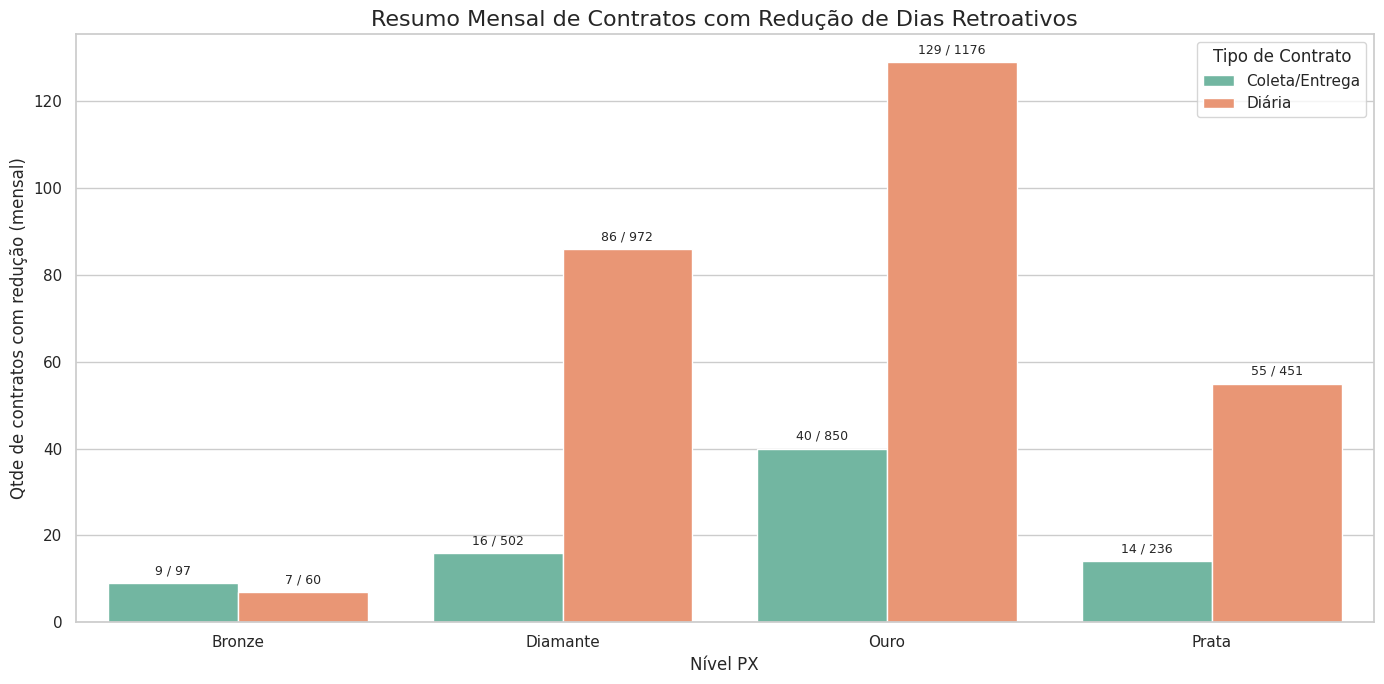

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 7))
sns.barplot(
    data=resumo_taxa_nivel,
    x='nivel_px',
    y='estimado_mensal_reducao',
    hue='tipo',
    palette='Set2'
)

# Adiciona r√≥tulos com valores totais por grupo
for i, row in resumo_taxa_nivel.iterrows():
    x_pos = list(resumo_taxa_nivel['nivel_px'].unique()).index(row['nivel_px']) + (0.2 if row['tipo'] == 'Di√°ria' else -0.2)
    plt.text(
        x=x_pos,
        y=row['estimado_mensal_reducao'] + 2,
        s=f"{row['estimado_mensal_reducao']} / {row['estimado_mensal_total']}",
        ha='center',
        fontsize=9
    )

plt.title("Resumo Mensal de Contratos com Redu√ß√£o de Dias Retroativos", fontsize=16)
plt.ylabel("Qtde de contratos com redu√ß√£o (mensal)")
plt.xlabel("N√≠vel PX")
plt.legend(title="Tipo de Contrato")
plt.tight_layout()
plt.show()


In [ ]:
# Adiciona uma coluna com texto para relat√≥rio
resumo_taxa_nivel['resumo'] = resumo_taxa_nivel.apply(
    lambda row: (
        f"No n√≠vel {row['nivel_px']} do tipo {row['tipo']}, estima-se que {row['estimado_mensal_reducao']}\n "
        f"dos {row['estimado_mensal_total']} contratos mensais sofram redu√ß√£o de dias retroativos,"
        f"representando {row['estimado_mensal_percentual']}% do total."
    ),
    axis=1
)

# Imprimir par√°grafos prontos
for texto in resumo_taxa_nivel['resumo']:
    print(texto)

No n√≠vel Bronze do tipo Coleta/Entrega, estima-se que 9
 dos 97 contratos mensais sofram redu√ß√£o de dias retroativos,representando 8.1% do total.
No n√≠vel Diamante do tipo Coleta/Entrega, estima-se que 16
 dos 502 contratos mensais sofram redu√ß√£o de dias retroativos,representando 3.1% do total.
No n√≠vel Ouro do tipo Coleta/Entrega, estima-se que 40
 dos 850 contratos mensais sofram redu√ß√£o de dias retroativos,representando 4.7% do total.
No n√≠vel Prata do tipo Coleta/Entrega, estima-se que 14
 dos 236 contratos mensais sofram redu√ß√£o de dias retroativos,representando 6.0% do total.
No n√≠vel Bronze do tipo Di√°ria, estima-se que 7
 dos 60 contratos mensais sofram redu√ß√£o de dias retroativos,representando 10.1% do total.
No n√≠vel Diamante do tipo Di√°ria, estima-se que 86
 dos 972 contratos mensais sofram redu√ß√£o de dias retroativos,representando 8.9% do total.
No n√≠vel Ouro do tipo Di√°ria, estima-se que 129
 dos 1176 contratos mensais sofram redu√ß√£o de dias retroat

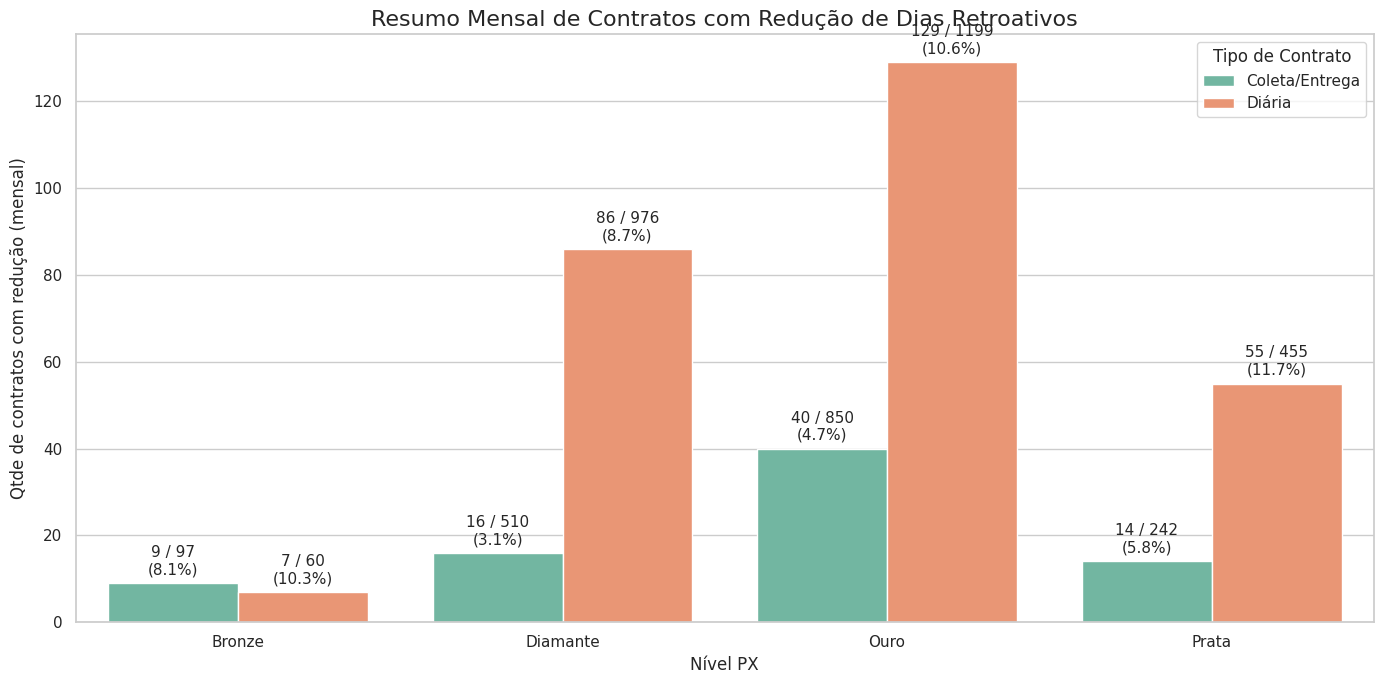

In [57]:
# Recriar o DataFrame resumo_taxa_nivel manualmente com base na estrutura fornecida

import pandas as pd

resumo_taxa_nivel = pd.DataFrame({
    'tipo': [
        'Coleta/Entrega', 'Coleta/Entrega', 'Coleta/Entrega', 'Coleta/Entrega',
        'Di√°ria', 'Di√°ria', 'Di√°ria', 'Di√°ria'
    ],
    'nivel_px': [
        'Bronze', 'Diamante', 'Ouro', 'Prata',
        'Bronze', 'Diamante', 'Ouro', 'Prata'
    ],
    'media_contratos_com_reducao': [2.875, 5.250, 13.375, 4.625, 2.375, 28.750, 43.125, 18.375],
    'media_contratos_total': [32.250, 170.000, 283.500, 80.500, 19.875, 325.375, 399.625, 151.625],
    'media_proporcao': [0.080792, 0.030563, 0.046782, 0.058001, 0.102940, 0.086886, 0.105965, 0.117266],
    'estimado_mensal_reducao': [9, 16, 40, 14, 7, 86, 129, 55],
    'estimado_mensal_total': [97, 510, 850, 242, 60, 976, 1199, 455],
    'estimado_mensal_percentual': [8.1, 3.1, 4.7, 5.8, 10.3, 8.7, 10.6, 11.7]
})

# Gerar o gr√°fico com r√≥tulos contendo valor absoluto + percentual
plt.figure(figsize=(14, 7))
sns.barplot(
    data=resumo_taxa_nivel,
    x='nivel_px',
    y='estimado_mensal_reducao',
    hue='tipo',
    palette='Set2'
)

# Adicionar r√≥tulos com valor absoluto + percentual
for i, row in resumo_taxa_nivel.iterrows():
    deslocamento = 0.2 if row['tipo'] == 'Di√°ria' else -0.2
    x_pos = list(resumo_taxa_nivel['nivel_px'].unique()).index(row['nivel_px']) + deslocamento

    texto = f"{int(row['estimado_mensal_reducao'])} / {int(row['estimado_mensal_total'])}\n({row['estimado_mensal_percentual']:.1f}%)"
    
    plt.text(
        x=x_pos,
        y=row['estimado_mensal_reducao'] + 2,
        s=texto,
        ha='center',
        fontsize=11
    )

plt.title("Resumo Mensal de Contratos com Redu√ß√£o de Dias Retroativos", fontsize=16)
plt.ylabel("Qtde de contratos com redu√ß√£o (mensal)")
plt.xlabel("N√≠vel PX")
plt.legend(title="Tipo de Contrato")
plt.tight_layout()
plt.show()


Durante o per√≠odo avaliado, foi poss√≠vel estimar a m√©dia mensal de contratos realizados e daqueles que passaram por redu√ß√£o retroativa de dias, segmentando por tipo de contrato (Di√°ria e Coleta/Entrega) e n√≠vel PX (Bronze, Prata, Ouro, Diamante). As estimativas t√™m como base m√©dias apuradas a cada 10 dias, posteriormente projetadas para o m√™s por meio de multiplica√ß√£o por tr√™s ‚Äî uma abordagem que reflete um cen√°rio operacional t√≠pico.

Os contratos do tipo Di√°ria apresentaram, de forma geral, os maiores percentuais de redu√ß√£o. Destaque para o n√≠vel Prata, com 11,1% dos contratos mensais sofrendo redu√ß√£o (51 de 451), seguido de perto por Ouro com 10,5% (125 de 1176), e Bronze com 10,1% (7 de 60). Esses resultados indicam que os contratos Di√°rios, especialmente nos n√≠veis mais operacionais, est√£o mais suscet√≠veis a ajustes retroativos ‚Äî possivelmente pela natureza mais rotativa, informal ou de menor controle desses servi√ßos.

Nos contratos do tipo Coleta/Entrega, o comportamento foi mais est√°vel, por√©m com varia√ß√µes relevantes. O n√≠vel Bronze apresentou 8,1% de redu√ß√£o (9 de 97 contratos), enquanto o n√≠vel Prata teve 5,6% (13 de 236). J√° os n√≠veis mais elevados apresentaram as menores taxas: Ouro com 4,2% (36 de 850) e Diamante com apenas 2,8% (14 de 502) ‚Äî o menor √≠ndice de todos os grupos avaliados.

Esses padr√µes refor√ßam que a probabilidade de redu√ß√£o retroativa de dias est√° fortemente associada ao tipo e ao n√≠vel do contrato, sendo mais expressiva entre os contratos Di√°rios e em n√≠veis PX mais baixos. Tais informa√ß√µes podem orientar a√ß√µes preventivas, como maior rigor nos crit√©rios de qualifica√ß√£o de prestadores, refor√ßo nos mecanismos de controle e acompanhamento das entregas, especialmente nas faixas com maior vulnerabilidade a inconsist√™ncias operacionais.

# ANALISE DIAS RETROATIVOS REMOVIDOS

A partir da base de contratos finalizados com informa√ß√µes sobre os dias contratados e os dias efetivamente trabalhados, foi calculado o risco estimado de um contrato sofrer redu√ß√£o de dias ap√≥s a solicita√ß√£o de adiantamento. Para tornar essa estimativa mais robusta, utilizamos uma abordagem Bayesiana com suaviza√ß√£o spline, o que permite considerar o comportamento geral da base mesmo em casos com poucos dados. A fun√ß√£o resultante estima o risco com base na propor√ß√£o cumprida do contrato no momento da antecipa√ß√£o. Em seguida, para cada dura√ß√£o de contrato, foi aplicada uma t√©cnica inspirada no m√©todo do cotovelo para identificar o ponto cr√≠tico da curva de risco ‚Äî chamado de dia_virada ‚Äî que indica o dia m√≠nimo recomendado para solicitar adiantamento com risco estabilizado.

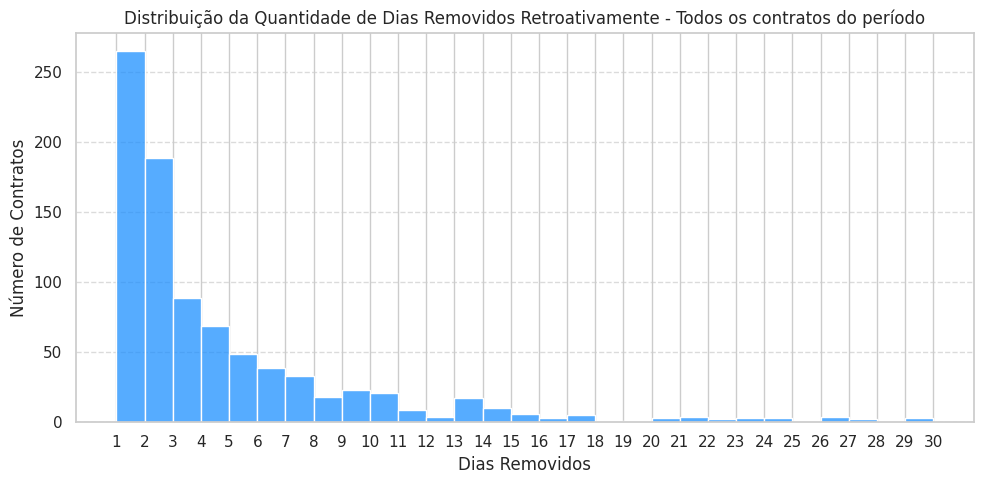

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Supondo que voc√™ tenha uma coluna chamada 'dias_reducao' no DataFrame com os dias efetivamente removidos
# E que voc√™ esteja trabalhando com df_todos_retroativos ou um DataFrame similar

plt.figure(figsize=(10, 5))
sns.histplot(df_original['dias_reducao'], bins=range(1, 31), kde=False, color='dodgerblue')

plt.title('Distribui√ß√£o da Quantidade de Dias Removidos Retroativamente - Todos os contratos do per√≠odo')
plt.xlabel('Dias Removidos')
plt.ylabel('N√∫mero de Contratos')
plt.xticks(range(1, 31, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
df_original.describe()

periodo     freight_id  contract_days_inicial  \
count                            970     970.000000             970.000000   
mean   2025-03-02 16:18:18.556700928  148007.538144              13.674227   
min              2025-02-01 00:00:00  139326.000000               1.500000   
25%              2025-02-11 00:00:00  143601.250000               6.000000   
50%              2025-03-01 00:00:00  147669.000000              11.000000   
75%              2025-03-21 00:00:00  152221.000000              19.000000   
max              2025-04-11 00:00:00  159082.000000              63.000000   
std                              NaN    5280.167969               9.567238   

       dias_reducao  
count    970.000000  
mean       4.090722  
min        0.500000  
25%        1.000000  
50%        2.000000  
75%        5.000000  
max       32.000000  
std        4.944325

In [60]:
#  eliminando outliers

q1 = df_original['dias_reducao'].quantile(0.25)
q3 = df_original['dias_reducao'].quantile(0.75)
iqr = q3 - q1

limite_inferior = q1 - 2 * iqr
limite_superior = q3 + 2 * iqr

df_original = df_original[
    (df_original['dias_reducao'] >= limite_inferior) &
    (df_original['dias_reducao'] <= limite_superior)]

df_original

periodo  freight_id            tipo  nivel_px  contract_days_inicial  \
0   2025-04-11      159082  Coleta/Entrega     Prata                    4.0   
1   2025-04-11      159066  Coleta/Entrega      Ouro                    3.0   
2   2025-04-11      159056          Di√°ria  Diamante                    1.5   
4   2025-04-11      158876          Di√°ria  Diamante                   13.0   
5   2025-04-11      158809          Di√°ria  Diamante                    4.0   
..         ...         ...             ...       ...                    ...   
964 2025-02-01      139378  Coleta/Entrega  Diamante                   23.0   
965 2025-02-01      139359  Coleta/Entrega  Diamante                    8.0   
966 2025-02-01      139352  Coleta/Entrega      Ouro                    3.0   
968 2025-02-01      139344          Di√°ria  Diamante                   28.0   
969 2025-02-01      139326          Di√°ria  Diamante                   28.0   

     dias_reducao  
0             2.0  
1             2.0  
2             0.5  
4             8.0  
5             1.0  
..            ...  
964           8.0  
965           1.0  
966           1.0  
968           6.0  
969           4.0  

[874 rows x 6 columns]

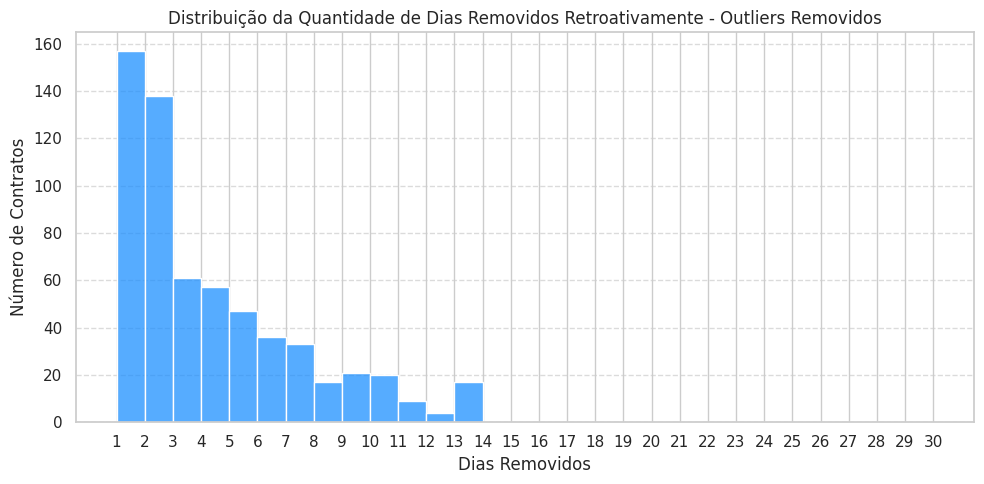

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Supondo que voc√™ tenha uma coluna chamada 'dias_reducao' no DataFrame com os dias efetivamente removidos
# E que voc√™ esteja trabalhando com df_todos_retroativos ou um DataFrame similar

df_original = df_original.loc[(df_original.nivel_px != 'Bronze')&(df_original.contract_days_inicial > 5)]
plt.figure(figsize=(10, 5))
sns.histplot(df_original['dias_reducao'], bins=range(1, 31), kde=False, color='dodgerblue')

plt.title('Distribui√ß√£o da Quantidade de Dias Removidos Retroativamente - Outliers Removidos')
plt.xlabel('Dias Removidos')
plt.ylabel('N√∫mero de Contratos')
plt.xticks(range(1, 31, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [65]:
df_original.describe()

periodo     freight_id  contract_days_inicial  \
count                            694     694.000000             694.000000   
mean   2025-03-01 02:54:17.636887552  147606.997118              15.701009   
min              2025-02-01 00:00:00  139326.000000               5.500000   
25%              2025-02-11 00:00:00  143486.500000               9.500000   
50%              2025-03-01 00:00:00  147248.500000              13.000000   
75%              2025-03-21 00:00:00  151614.000000              20.000000   
max              2025-04-11 00:00:00  158876.000000              50.000000   
std                              NaN    5045.225146               8.754896   

       dias_reducao  
count    694.000000  
mean       3.578530  
min        0.500000  
25%        1.000000  
50%        2.000000  
75%        5.000000  
max       13.000000  
std        3.162727

In [ ]:
# criando df_todos

reduzidos = df_original[['freight_id', 'tipo', 'nivel_px', 'contract_days_inicial','dias_reducao']].copy()
todos = df_todos_retroativos[['freight_id', 'tipo', 'nivel_px', 'contract_days']].copy()

df_todos = pd.merge(todos,reduzidos,
    on=['freight_id', 'tipo', 'nivel_px'],
    how='left')


df_todos.loc[df_todos['contract_days_inicial'].isna(), 'contract_days_inicial'] = df_todos['contract_days']

df_todos['dias_reducao'] = df_todos['dias_reducao'].fillna(0)

df_todos['houve_reducao'] = df_todos['dias_reducao'] != 0

df_todos = df_todos.loc[df_todos.contract_days_inicial > 0] 

# Criar vari√°vel de propor√ß√£o de redu√ß√£o (evitar divis√£o por zero)
df_todos['proporcao_reducao'] = df_todos.apply(
    lambda row: row['dias_reducao'] / row['contract_days_inicial'] if row['contract_days_inicial'] > 0 else 0,
    axis=1).round(4)

df_todos = df_todos[['tipo', 'nivel_px', 'houve_reducao', "contract_days_inicial","dias_reducao",'proporcao_reducao']]

df_todos.to_csv("src/data/df_todos.csv")

df_todos


tipo  nivel_px  houve_reducao  contract_days_inicial  \
0              Di√°ria      Ouro          False                    3.0   
1      Coleta/Entrega  Diamante          False                    7.0   
2              Di√°ria      Ouro           True                   15.0   
3              Di√°ria      Ouro          False                    7.0   
4      Coleta/Entrega  Diamante          False                    1.0   
...               ...       ...            ...                    ...   
11604          Di√°ria  Diamante          False                    1.0   
11605  Coleta/Entrega  Diamante          False                    1.0   
11606  Coleta/Entrega  Diamante          False                    1.0   
11607  Coleta/Entrega     Prata          False                    1.0   
11608  Coleta/Entrega      Ouro          False                    1.0   

       dias_reducao  proporcao_reducao  
0               0.0             0.0000  
1               0.0             0.0000  
2               4.0             0.2667  
3               0.0             0.0000  
4               0.0             0.0000  
...             ...                ...  
11604           0.0             0.0000  
11605           0.0             0.0000  
11606           0.0             0.0000  
11607           0.0             0.0000  
11608           0.0             0.0000  

[11603 rows x 6 columns]

In [ ]:
df_todos.(dias_inicial == 1)

In [ ]:
# calculo do risco_bruto

df_todos['contract_days_inicial'] = df_todos['contract_days_inicial'].round(0).astype(int)
df_todos['dias_reducao'] = df_todos['dias_reducao'].fillna(0).round(0).astype(int)

# Gerar risco bruto para dias_reducao de 1 a 20
resultados_risco = []

for dia_alvo in range(1, 21):
    grupos = df_todos.groupby(['tipo', 'nivel_px', 'contract_days_inicial'])
    
    for (tipo, nivel, duracao), grupo in grupos:
        total = len(grupo)
        if total == 0:
            continue

        risco = (grupo['dias_reducao'] >= dia_alvo).sum() / total

        resultados_risco.append({
            'tipo': tipo,
            'nivel_px': nivel,
            'contract_days_inicial': duracao,
            'dias_reducao_alvo': dia_alvo,
            'risco_estimado_bruto': round(risco, 4),
            'n_total': total
        })

df_risco_bruto = pd.DataFrame(resultados_risco)
df_risco_bruto.to_csv("src/data/df_risco_bruto.csv")
df_risco_bruto

tipo nivel_px  contract_days_inicial  dias_reducao_alvo  \
0     Coleta/Entrega   Bronze                      1                  1   
1     Coleta/Entrega   Bronze                      2                  1   
2     Coleta/Entrega   Bronze                      3                  1   
3     Coleta/Entrega   Bronze                      4                  1   
4     Coleta/Entrega   Bronze                      5                  1   
...              ...      ...                    ...                ...   
5835          Di√°ria    Prata                     42                 20   
5836          Di√°ria    Prata                     43                 20   
5837          Di√°ria    Prata                     45                 20   
5838          Di√°ria    Prata                     49                 20   
5839          Di√°ria    Prata                     50                 20   

      risco_estimado_bruto  n_total  
0                   0.0000       91  
1                   0.0938       32  
2                   0.1111       36  
3                   0.1818       22  
4                   0.1667       30  
...                    ...      ...  
5835                0.0000        1  
5836                0.0000        1  
5837                0.0000        2  
5838                0.0000        1  
5839                0.0000        1  

[5840 rows x 6 columns]

In [ ]:
# Calcular o risco bayesiano com alpha=10 e p0 vari√°vel por dias_reducao_alvo
alpha = 10

# Calcular p0 (prior) para cada valor de dias_reducao_alvo
p0_dict = {}
total_geral = len(df_todos)

for dia_alvo in range(1, 21):
    p0_dict[dia_alvo] = (df_todos['dias_reducao'] >= dia_alvo).sum() / total_geral

# Adicionar coluna de risco bayesiano ao df_risco_bruto
df_risco_bruto['risco_estimado_bayesiano'] = df_risco_bruto.apply(
    lambda row: round(
        (row['risco_estimado_bruto'] * row['n_total'] + alpha * p0_dict[row['dias_reducao_alvo']]) / (row['n_total'] + alpha),
        4
    ),
    axis=1
)

df_risco_bruto = df_risco_bruto.loc[df_risco_bruto.contract_days_inicial > df_risco_bruto.dias_reducao_alvo]
df_risco_bruto.head(10)


tipo nivel_px  contract_days_inicial  dias_reducao_alvo  \
1   Coleta/Entrega   Bronze                      2                  1   
2   Coleta/Entrega   Bronze                      3                  1   
3   Coleta/Entrega   Bronze                      4                  1   
4   Coleta/Entrega   Bronze                      5                  1   
5   Coleta/Entrega   Bronze                      6                  1   
6   Coleta/Entrega   Bronze                      7                  1   
7   Coleta/Entrega   Bronze                      8                  1   
8   Coleta/Entrega   Bronze                      9                  1   
9   Coleta/Entrega   Bronze                     10                  1   
10  Coleta/Entrega   Bronze                     11                  1   

    risco_estimado_bruto  n_total  risco_estimado_bayesiano  
1                 0.0938       32                    0.0877  
2                 0.1111       36                    0.1017  
3                 0.1818       22                    0.1463  
4                 0.1667       30                    0.1420  
5                 0.1111       18                    0.0957  
6                 0.3333        6                    0.1675  
7                 0.2500        4                    0.1201  
8                 0.0000        5                    0.0454  
9                 0.3333        3                    0.1293  
10                0.2000        5                    0.1121

/tmp/ipykernel_8904/3521423981.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.average(x['risco_estimado_bayesiano'], weights=x['n_total']))


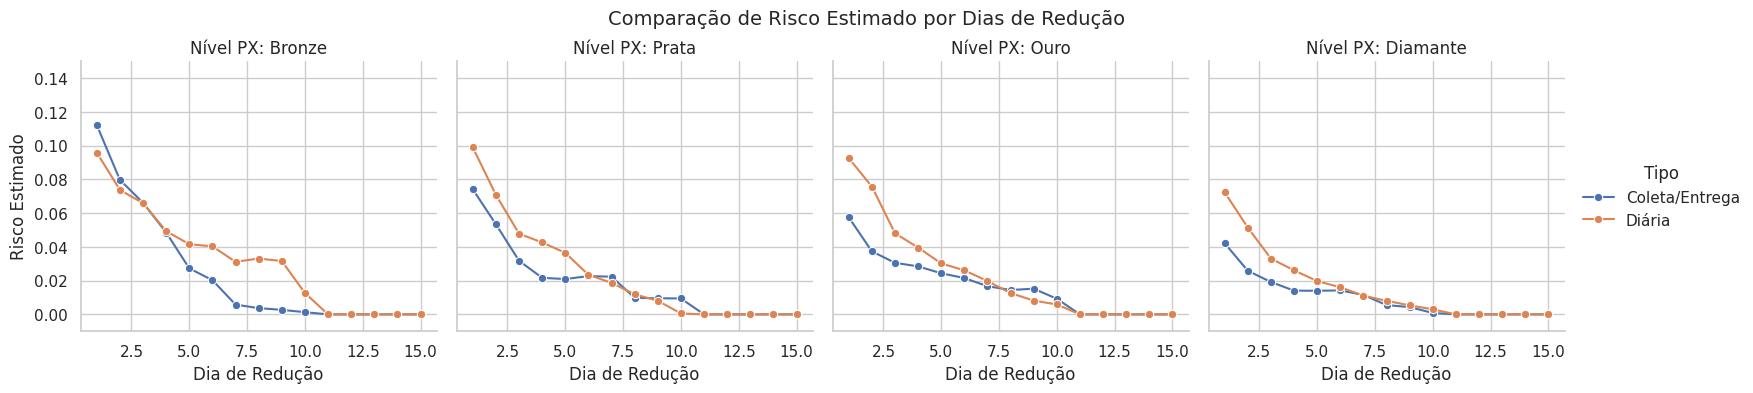

In [ ]:
# Regerar gr√°fico com grid (atualizando a vers√£o enviada pelo usu√°rio)
import seaborn as sns
import matplotlib.pyplot as plt

# Agrupamento por n√≠vel, tipo e dias alvo ‚Äî m√©dia ponderada bayesiana
df_plot1 = (
    df_risco_bruto[df_risco_bruto['dias_reducao_alvo'] <= 15]
    .groupby(['nivel_px', 'tipo', 'dias_reducao_alvo'])
    .apply(lambda x: np.average(x['risco_estimado_bayesiano'], weights=x['n_total']))
    .reset_index(name='risco_medio_ponderado')
)

# Ordem fixa dos n√≠veis
ordem_niveis = ['Bronze', 'Prata', 'Ouro', 'Diamante']
df_plot1['nivel_px'] = pd.Categorical(df_plot1['nivel_px'], categories=ordem_niveis, ordered=True)

# Gr√°fico com linhas de grade
g1 = sns.FacetGrid(df_plot1, col="nivel_px", col_wrap=4, height=4, sharey=True)
g1.map_dataframe(sns.lineplot, x="dias_reducao_alvo", y="risco_medio_ponderado", hue="tipo", marker='o')
g1.set_titles("N√≠vel PX: {col_name}")
g1.set_axis_labels("Dia de Redu√ß√£o", "Risco Estimado")
g1.set(ylim=(-0.01, 0.15))
g1.add_legend(title="Tipo")

# Adicionar grid manualmente para cada subplot
for ax in g1.axes.flat:
    ax.grid(True)

g1.fig.suptitle("Compara√ß√£o de Risco Estimado por Dias de Redu√ß√£o", fontsize=14)
plt.subplots_adjust(top=0.85)
plt.show()




### Contratos tipo "Di√°ria" apresentam mais risco que "Coleta/Entrega" em todos os n√≠veis PX ###

A linha laranja est√° consistentemente acima da azul em todos os subgr√°ficos.

Isso indica que contratos do tipo Di√°ria t√™m maior probabilidade de sofrer redu√ß√£o , mesmo com poucos dias de contrato.

### O risco cai rapidamente nos primeiros dias ###

Para ambos os tipos de contrato, a maior queda no risco ocorre entre os dias 1 e 3.

Ap√≥s isso, o risco se estabiliza ou reduz mais lentamente, o que pode indicar que a maioria das redu√ß√µes acontece no in√≠cio do contrato.

### Diferen√ßas entre n√≠veis PX s√£o pequenas em escala <10% ###

Embora Bronze e Prata tenham risco um pouco mais alto no in√≠cio, todos os n√≠veis PX convergem para risco abaixo de 2% ap√≥s o dia 6-7.

Isso sugere que n√≠vel PX influencia mais o risco no in√≠cio do contrato.



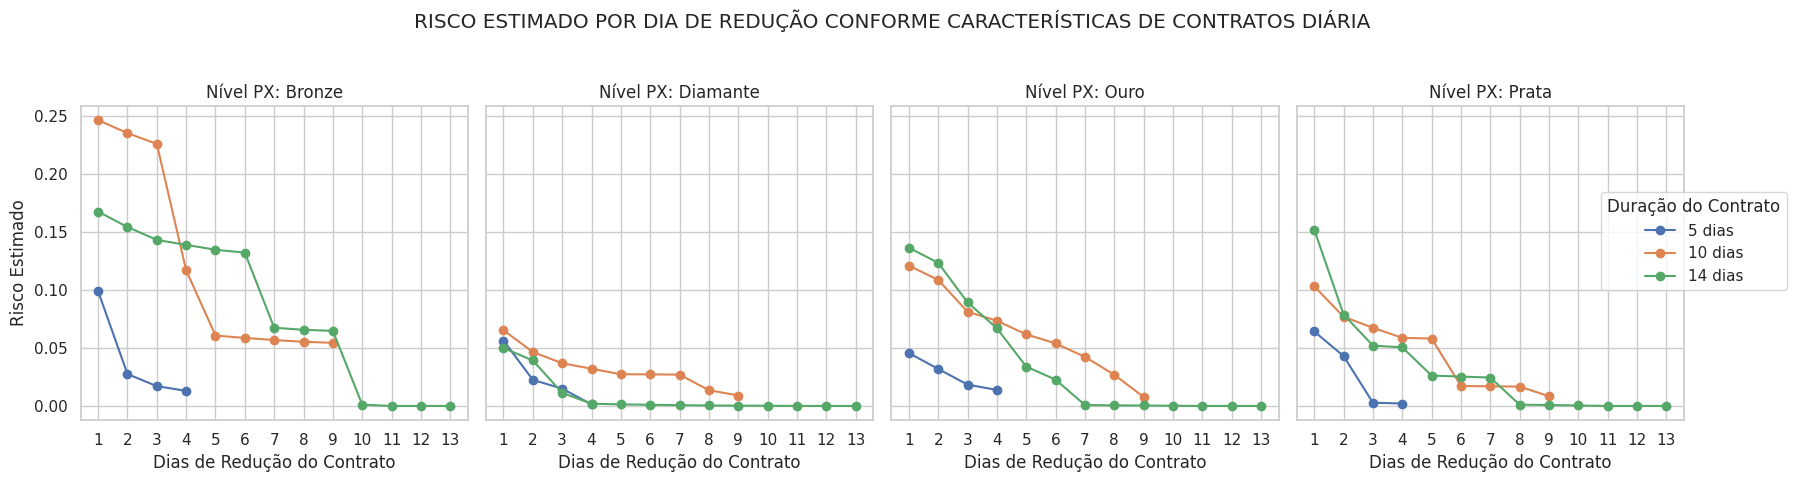

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# Dura√ß√µes desejadas
duracoes_plot = [5, 10, 14]

# Filtrar apenas contratos do tipo "Di√°ria"
df_diaria = df_risco_bruto[
    (df_risco_bruto['tipo'] == 'Di√°ria') &
    (df_risco_bruto['contract_days_inicial'].isin(duracoes_plot))
]

# Listar n√≠veis PX dispon√≠veis
niveis_px_disponiveis = df_diaria['nivel_px'].unique()

# Criar gr√°fico por n√≠vel PX
fig, axs = plt.subplots(1, len(niveis_px_disponiveis), figsize=(18, 5), sharey=True)

# Armazenar handles/labels para uma √∫nica legenda
handles_legenda = []
labels_legenda = []

for ax, nivel in zip(axs, niveis_px_disponiveis):
    df_nivel = df_diaria[df_diaria['nivel_px'] == nivel]
    for duracao in duracoes_plot:
        dados = df_nivel[df_nivel['contract_days_inicial'] == duracao].sort_values('dias_reducao_alvo')
        linha, = ax.plot(
            dados['dias_reducao_alvo'],
            dados['risco_estimado_bayesiano'],
            marker='o',
            label=f'{duracao} dias'
        )
        if f'{duracao} dias' not in labels_legenda:
            handles_legenda.append(linha)
            labels_legenda.append(f'{duracao} dias')
    ax.set_title(f'N√≠vel PX: {nivel}')
    ax.set_xlabel('Dias de Redu√ß√£o do Contrato')
    ax.grid(True)
    ax.xaxis.set_major_locator(MultipleLocator(1))  # ‚úÖ Eixo X com apenas inteiros

# Eixo Y
axs[0].set_ylabel('Risco Estimado')

# T√≠tulo e legenda final
fig.suptitle('RISCO ESTIMADO POR DIA DE REDU√á√ÉO CONFORME CARACTER√çSTICAS DE CONTRATOS DI√ÅRIA')
fig.legend(handles=handles_legenda, labels=labels_legenda, title='Dura√ß√£o do Contrato', loc='center right')


plt.tight_layout(rect=[0, 0.02, 0.95, 0.95])
plt.show()


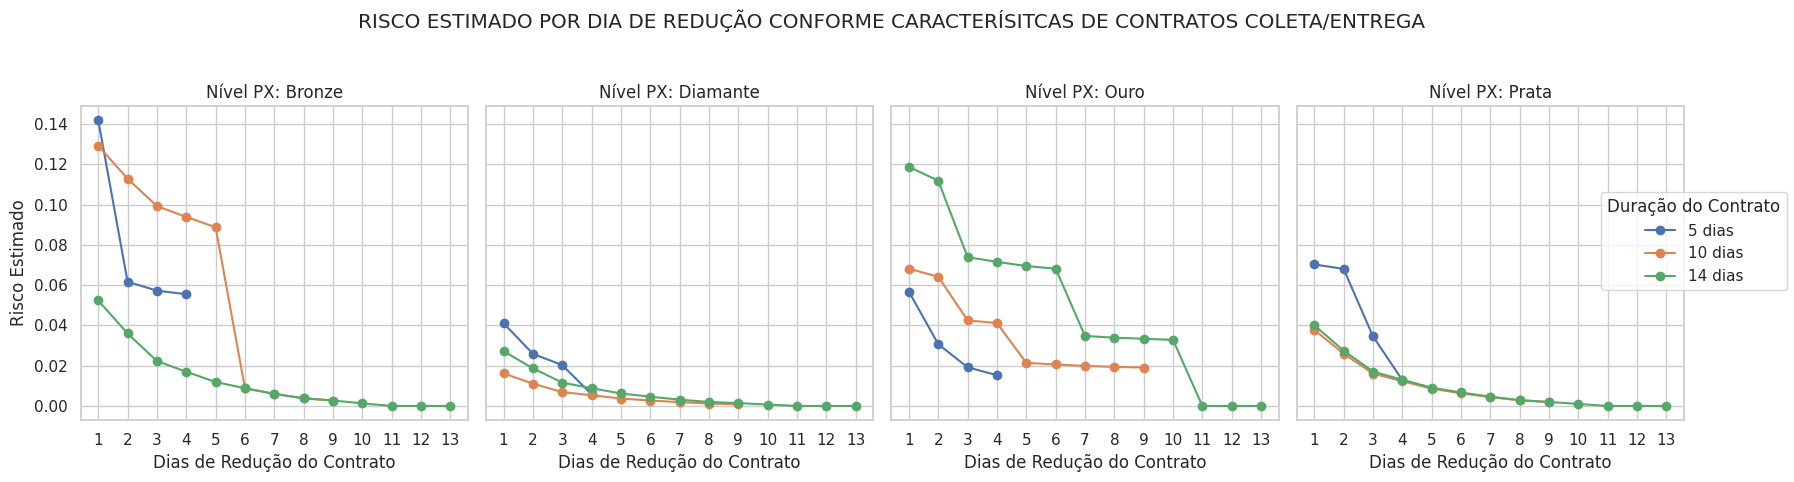

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# Duracoes desejadas para tra√ßar
duracoes_plot = [5, 10, 14]

# Filtrar apenas contratos do tipo "Coleta/Entrega" para essas dura√ß√µes
df_coleta = df_risco_bruto[
    (df_risco_bruto['tipo'] == 'Coleta/Entrega') &
    (df_risco_bruto['contract_days_inicial'].isin(duracoes_plot))
]

# Listar n√≠veis PX dispon√≠veis
niveis_px_disponiveis = df_coleta['nivel_px'].unique()

# Gerar um gr√°fico por n√≠vel PX
fig, axs = plt.subplots(1, len(niveis_px_disponiveis), figsize=(18, 5), sharey=True)

handles_legenda = []
labels_legenda = []

for ax, nivel in zip(axs, niveis_px_disponiveis):
    df_nivel = df_coleta[df_coleta['nivel_px'] == nivel]
    for duracao in duracoes_plot:
        dados = df_nivel[df_nivel['contract_days_inicial'] == duracao].sort_values('dias_reducao_alvo')
        linha, = ax.plot(
            dados['dias_reducao_alvo'],
            dados['risco_estimado_bayesiano'],
            marker='o',
            label=f'{duracao} dias'
        )
        if f'{duracao} dias' not in labels_legenda:
            handles_legenda.append(linha)
            labels_legenda.append(f'{duracao} dias')
    ax.set_title(f'N√≠vel PX: {nivel}')
    ax.set_xlabel('Dias de Redu√ß√£o do Contrato')
    ax.grid(True)
    ax.xaxis.set_major_locator(MultipleLocator(1))  # üîß For√ßa inteiros no eixo X

axs[0].set_ylabel('Risco Estimado')
fig.suptitle('RISCO ESTIMADO POR DIA DE REDU√á√ÉO CONFORME CARACTER√çSITCAS DE CONTRATOS COLETA/ENTREGA')
fig.legend(handles=handles_legenda, labels=labels_legenda, title='Dura√ß√£o do Contrato', loc='center right')


plt.tight_layout(rect=[0, 0.02, 0.95, 0.95])
plt.show()



Os gr√°ficos exibem o risco estimado de redu√ß√£o de dias em contratos PX, separados por tipo de contrato ‚Äî Di√°ria (primeiro gr√°fico) e Coleta/Entrega (segundo gr√°fico) ‚Äî e por n√≠vel PX (Bronze, Prata, Ouro, Diamante). Cada linha representa a evolu√ß√£o do risco conforme aumentam os dias de redu√ß√£o, diferenciando as curvas para contratos de 5, 10, 15 e 20 dias de dura√ß√£o inicial. Quanto maior o n√∫mero de dias reduzidos, menor tende a ser o risco, refletindo uma curva decrescente. No entanto, a taxa de queda e a forma da curva variam entre n√≠veis e tipos, revelando diferentes padr√µes de comportamento.

Contratos mais longos (20 dias) apresentam maior resili√™ncia a redu√ß√µes, com curvas mais suaves e riscos mais distribu√≠dos ao longo dos dias.

Contratos curtos (5 dias) concentram o risco nos primeiros dias, com quedas abruptas logo no in√≠cio ‚Äî especialmente no n√≠vel Bronze, sugerindo vulnerabilidade imediata a redu√ß√µes.

Para n√≠veis superiores (Ouro e Diamante), observa-se uma suaviza√ß√£o dos riscos independentemente da dura√ß√£o, o que pode indicar maior estabilidade na opera√ß√£o.

Os gr√°ficos revelam pontos de inflex√£o (cotovelos) nos quais o risco deixa de cair acentuadamente, sugerindo limiares √≥timos de redu√ß√£o com impacto minimizado.

